In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils

### ORF

In [2]:
# Read ORF cosine similarities

orf_similarity_percentile_df = pd.read_parquet('cos_sim/cosine_similarities_percentile_genes_orf.parquet')

In [3]:
# Genes of interest
genes = ["INSYN1", "PIK3R3","RAB40B", "RAB40C"]

In [4]:
# Identify connections between genes of interest and all other genes

connections_df = orf_similarity_percentile_df[genes]

connections_df =connections_df.stack().reset_index().rename(columns={0:"percentile"})

connections_df = pd.concat(
    [
        connections_df,
        connections_df.rename(columns={"gene_1": "gene_2", "gene_2": "gene_1"}),
    ],
    ignore_index=True,
).drop_duplicates()

connections_df.head()

,gene_1,gene_2,percentile
0,A4GALT,INSYN1,0.097016
1,A4GALT,PIK3R3,0.870580
2,A4GALT,RAB40B,0.236004
3,A4GALT,RAB40C,0.380576
4,A4GNT,INSYN1,0.155635


In [5]:
# Add knowledge graph information and filter out any connections with low knowledge graph scores

knowledge_graph = pd.read_csv(
    "~/Downloads/orf_scores_merged.zip",
    sep="\t",
    usecols=["GENE1", "GENE2", "gene_mf__go", "gene_bp__go", "gene_pathway"],
).rename(
    columns={
        "GENE1": "gene_1",
        "GENE2": "gene_2",
        "gene_mf__go": "gene_mf",
        "gene_bp__go": "gene_bp",
    }
)

knowledge_graph = pd.concat(
    [
        knowledge_graph,
        knowledge_graph.rename(columns={"gene_1": "gene_2", "gene_2": "gene_1"}),
    ],
    ignore_index=True,
)

knowledge_graph = (
    knowledge_graph.assign(gene_kg=lambda x: np.max(
            x[["gene_mf", "gene_bp", "gene_pathway"]].abs(), axis=1
        )
    )
    .drop(columns=["gene_mf", "gene_bp", "gene_pathway"])
)

connections_df = connections_df.merge(
    knowledge_graph, on=["gene_1", "gene_2"], how="left"
)

connections_df = connections_df.query("gene_kg<0.4")

In [6]:
# Find the most similar genes for each ORF gene group (based on the cosine similarity percentile)

gene_list = []

for gene in genes:
    temp = connections_df.query("gene_1 == @gene").nlargest(columns="percentile", n=1)[
        "gene_2"
    ].to_list() + [gene]
    print(temp)
    gene_list.append(temp)

top_similar = np.unique(np.asarray(gene_list).flatten())

df = orf_similarity_percentile_df.loc[top_similar, top_similar]

for gene in top_similar:
    df.loc[gene, gene] = 1

['ZFP36L1', 'INSYN1']
['HOXC8', 'PIK3R3']
['NRBP1', 'RAB40B']
['NRBP1', 'RAB40C']


In [7]:
kg_df = (
    knowledge_graph[["gene_1", "gene_2", "gene_kg"]]
    .drop_duplicates()
    .pivot(columns="gene_1", index="gene_2", values="gene_kg")
    .loc[top_similar, top_similar]
    .fillna(1)
)

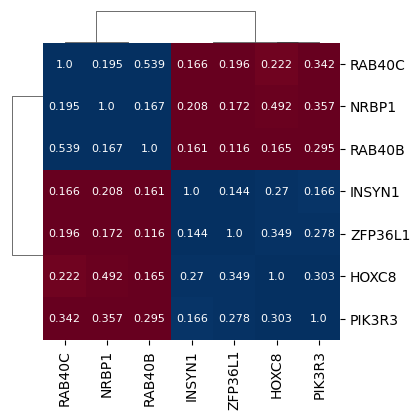

In [8]:
# Plot the heatmap

n_row = df.shape[0]
n_col = df.shape[1]
fig_width = n_row * 0.5 + 1
fig_height = n_col * 0.5 + 1

g = sns.clustermap(
    df,
    cmap="RdBu",
    vmin=0,
    vmax=1,
    dendrogram_ratio=(0.1, 0.1),
    figsize=(fig_width, fig_height),
    cbar_pos=None,
)

clustermap_df = g.data2d

for i in range(len(clustermap_df)):
    for j in range(len(clustermap_df.columns)):
        gene_1 = clustermap_df.index[i]
        gene_2 = clustermap_df.columns[j]
        kg_gene_pair = kg_df.loc[gene_1, gene_2]
        text = f"{kg_gene_pair}"
        x = j + 0.5  # Center the text horizontally
        y = i + 0.5  # Center the text vertically

        text_color = (
            "white"
            if clustermap_df.values[i, j] > 0.75 or clustermap_df.values[i, j] < 0.25
            else "black"
        )

        g.ax_heatmap.text(x, y, text, ha="center", va="center", color=text_color, fontdict={"size": 8})

g.ax_heatmap.set_xlabel("")
g.ax_heatmap.set_ylabel("")

plt.savefig(f"figures/ORF-connections-{'-'.join(top_similar)}.png", dpi=300)
plt.savefig(f"figures/ORF-connections-{'-'.join(top_similar)}.svg", dpi=300)

In [9]:
orf_metadata_df = pd.read_csv(
    "../00.download-and-process-annotations/output/orf_metadata.tsv.gz",
    sep="\t",
    usecols=["Metadata_JCP2022", "Metadata_Symbol"],
)

orf_profiles_with_feature_names_df = utils.consensus(
    pd.read_parquet("../profiles/profiles_wellpos_cc_var_mad_outlier_orf.parquet")
    .merge(orf_metadata_df, on="Metadata_JCP2022", how="inner")
    .query('Metadata_Symbol in @top_similar'),
    "Metadata_JCP2022",
)

orf_profiles_with_feature_names_df.head()

,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Symbol,Cells_AreaShape_Area,Cells_AreaShape_BoundingBoxArea,Cells_AreaShape_BoundingBoxMaximum_X,Cells_AreaShape_BoundingBoxMaximum_Y,Cells_AreaShape_BoundingBoxMinimum_X,...,Nuclei_Texture_Variance_RNA_10_02_256,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256
0,source_4,BR00121543,F05,JCP2022_900163,ZFP36L1,3.955000,8.235318,1.270378,2.040468,-0.046642,...,-1.505443,-1.541903,-1.383331,-1.367944,-1.369245,-1.385039,-1.381209,-1.368575,-1.368981,-1.455232
1,source_4,BR00123506,A11,JCP2022_906775,PIK3R3,-0.621158,0.344063,-0.871332,0.201460,-0.726466,...,1.288419,1.269413,1.269578,1.283547,1.268461,1.277935,1.282709,1.291205,1.280402,1.286843
2,source_4,BR00123526,M07,JCP2022_902925,NRBP1,-1.076419,-2.816711,0.221198,-1.777022,0.667677,...,1.296320,1.413859,1.376445,1.404406,1.430520,1.366660,1.317328,1.331847,1.386126,1.300114
3,source_4,BR00124781,N02,JCP2022_914070,NRBP1,-2.939544,-4.788945,0.369239,0.215277,0.872623,...,1.156265,1.174280,1.293464,1.239962,1.295648,1.266921,1.262969,1.139859,1.263777,1.233728
4,source_4,BR00124781,D21,JCP2022_913920,PIK3R3,0.260605,2.182515,0.773805,0.739552,0.479118,...,-2.802833,-2.904818,-2.850760,-2.915220,-2.921134,-2.916915,-2.857152,-2.884443,-2.959167,-2.922632


In [10]:
feature_names = utils.get_featurecols(orf_profiles_with_feature_names_df)

feature_name_interpretation_df = pd.DataFrame()

for feature_name in feature_names:
    df = pd.DataFrame(utils.parse_cp_features(feature_name), index=[0])
    feature_name_interpretation_df = pd.concat([feature_name_interpretation_df, df], ignore_index=True)

In [11]:
feature_group = "AreaShape"
feature_group_list = ["Texture", "Intensity", "RadialDistribution"]
compartments = ["Cells", "Cytoplasm", "Nuclei"]
channels = ["DNA", "RNA", "Mito", "ER", "AGP"]
Cluster1= ["RAB40B", "RAB40C", "NRBP1"]
Cluster2 = ["INSYN1", "PIK3R3", "ZFP36L1", "HOXC8"]

In [12]:
compartment_feature_group_df = pd.DataFrame()

for compartment in compartments:
    feature_cols = (
        feature_name_interpretation_df.query("feature_group==@feature_group")
        .query("compartment==@compartment")
        .feature.to_list()
    )
    feature_values_cluster1 = np.median(orf_profiles_with_feature_names_df.query('Metadata_Symbol in @Cluster1')[feature_cols].copy().values, axis=0)
    feature_values_cluster2 = np.median(orf_profiles_with_feature_names_df.query('Metadata_Symbol in @Cluster2')[feature_cols].copy().values, axis=0)
    feature_values = np.asarray([feature_values_cluster1, feature_values_cluster2])
    id = ["Cluster1", "Cluster2"]

    cosine_sim = utils.cosine_similarity(id, feature_values).values[0, 1]

    df = pd.DataFrame(
        {
            "Compartment": compartment,
            "Feature_group": feature_group,
            "Similarity": cosine_sim,
        },
        index=[0],
    )

    compartment_feature_group_df = pd.concat(
        [compartment_feature_group_df, df], ignore_index=True
    )

compartment_feature_group_df = compartment_feature_group_df.pivot(
    index="Feature_group", columns="Compartment", values="Similarity"
)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
print(compartment_feature_group_df.to_markdown())

| Feature_group   |     Cells |   Cytoplasm |    Nuclei |
|:----------------|----------:|------------:|----------:|
| AreaShape       | -0.830953 |   -0.863642 | -0.801077 |


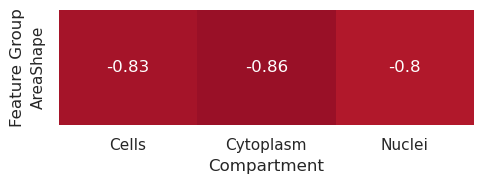

In [14]:
n_row = compartment_feature_group_df.shape[0]
n_col = compartment_feature_group_df.shape[1]
fig_width = n_row + 4
fig_height = 2
sns.set(font_scale=1)

plt.figure(figsize = (fig_width, fig_height))

f = sns.heatmap(
    compartment_feature_group_df,
    cmap="RdBu",
    vmin=-1,
    vmax=1,
    xticklabels=True,
    yticklabels=True,
    annot=True,
    cbar=None,
)

f.set(xlabel="Compartment", ylabel="Feature Group")

f.xaxis.label.set_size(12)
f.yaxis.label.set_size(12)
plt.tight_layout()

plt.savefig(f"figures/{'-'.join(top_similar)}_area_size_compartment.png")
plt.savefig(f"figures/{'-'.join(top_similar)}_area_size_compartment.svg")

In [15]:
channel_feature_group_df = pd.DataFrame()

for channel in channels:
    for feature_group in feature_group_list:
        feature_cols = (
            feature_name_interpretation_df.query("feature_group==@feature_group")
            .query("channel==@channel")
            .feature.to_list()
        )
        feature_values_cluster1 = np.median(orf_profiles_with_feature_names_df.query('Metadata_Symbol in @Cluster1')[feature_cols].copy().values, axis=0)
        feature_values_cluster2 = np.median(orf_profiles_with_feature_names_df.query('Metadata_Symbol in @Cluster2')[feature_cols].copy().values, axis=0)
        feature_values = np.asarray([feature_values_cluster1, feature_values_cluster2])
        id = ["Cluster1", "Cluster2"]

        cosine_sim = utils.cosine_similarity(id, feature_values).values[0, 1]

        df = pd.DataFrame(
            {
                "Channel": channel,
                "Feature_group": feature_group,
                "Similarity": cosine_sim,
            },
            index=[0],
        )

        channel_feature_group_df = pd.concat(
            [channel_feature_group_df, df], ignore_index=True
        )

channel_feature_group_df = channel_feature_group_df.pivot(
    index="Feature_group", columns="Channel", values="Similarity"
)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
print(channel_feature_group_df.to_markdown())

| Feature_group      |       AGP |       DNA |        ER |      Mito |       RNA |
|:-------------------|----------:|----------:|----------:|----------:|----------:|
| Intensity          | -0.889963 | -0.859488 | -0.894809 | -0.944878 | -0.877405 |
| RadialDistribution | -0.960996 | -0.887363 | -0.787968 | -0.851995 | -0.790242 |
| Texture            | -0.920884 | -0.803056 | -0.842558 | -0.910472 | -0.774294 |


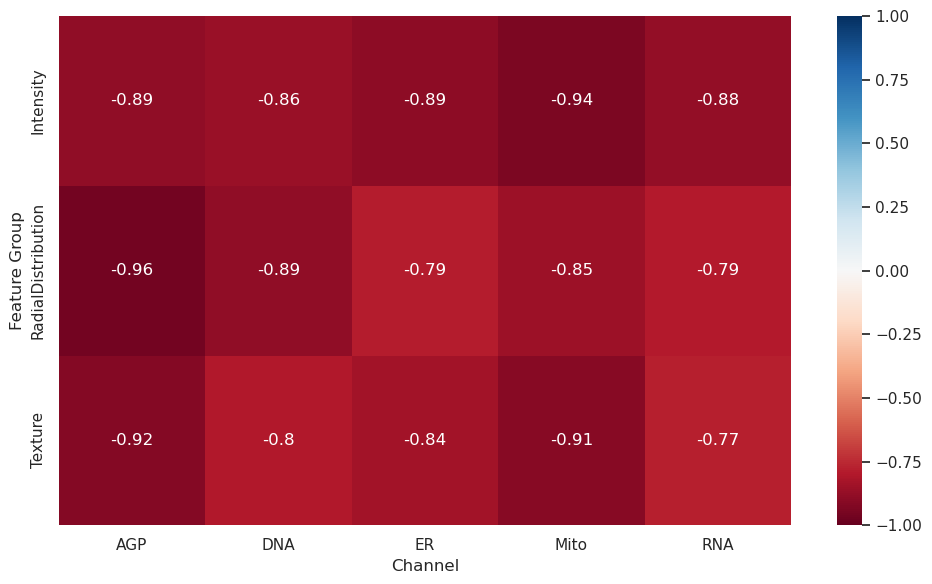

In [17]:
sns.set(font_scale=1)
plt.figure(figsize = (fig_width*2, fig_height*3))

f = sns.heatmap(
    channel_feature_group_df,
    cmap="RdBu",
    vmin=-1,
    vmax=1,
    xticklabels=True,
    yticklabels=True,
    annot=True,
)

f.set(xlabel="Channel", ylabel="Feature Group")

f.xaxis.label.set_size(12)
f.yaxis.label.set_size(12)
plt.tight_layout()
plt.savefig(f"figures/{'-'.join(top_similar)}_feature_group_channel.png")
plt.savefig(f"figures/{'-'.join(top_similar)}_feature_group_channel.svg")

### CRISPR

In [18]:
# Check connections in CRISPR as well

crispr_similarity_percentile_df = pd.read_parquet('cos_sim/cosine_similarities_percentile_genes_crispr.parquet')

In [19]:
# Genes of interest
genes = ["PIK3R3","RAB40B", "HOXC8", "ZFP36L1", "NRBP1"]

In [20]:
top_similar = genes

df = crispr_similarity_percentile_df.loc[top_similar, top_similar]

for gene in top_similar:
    df.loc[gene, gene] = 1

In [21]:
kg_df = (
    knowledge_graph[["gene_1", "gene_2", "gene_kg"]]
    .drop_duplicates()
    .pivot(columns="gene_1", index="gene_2", values="gene_kg")
    .loc[top_similar, top_similar]
    .fillna(1)
)

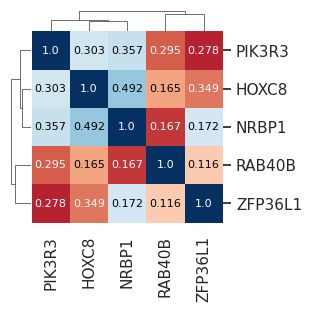

In [22]:
# Plot the heatmap

n_row = df.shape[0]
n_col = df.shape[1]
fig_width = n_row * 0.5 + 1
fig_height = n_col * 0.5 + 1

g = sns.clustermap(
    df,
    cmap="RdBu",
    vmin=0,
    vmax=1,
    dendrogram_ratio=(0.1, 0.1),
    figsize=(fig_width, fig_height),
    cbar_pos=None,
)

clustermap_df = g.data2d

for i in range(len(clustermap_df)):
    for j in range(len(clustermap_df.columns)):
        gene_1 = clustermap_df.index[i]
        gene_2 = clustermap_df.columns[j]
        kg_gene_pair = kg_df.loc[gene_1, gene_2]
        text = f"{kg_gene_pair}"
        x = j + 0.5  # Center the text horizontally
        y = i + 0.5  # Center the text vertically

        text_color = (
            "white"
            if clustermap_df.values[i, j] > 0.75 or clustermap_df.values[i, j] < 0.25
            else "black"
        )

        g.ax_heatmap.text(x, y, text, ha="center", va="center", color=text_color, fontdict={"size": 8})

g.ax_heatmap.set_xlabel("")
g.ax_heatmap.set_ylabel("")
plt.savefig(f"figures/CRISPR-connections-{'-'.join(top_similar)}.png", dpi=300)
plt.savefig(f"figures/CRISPR-connections-{'-'.join(top_similar)}.svg", dpi=300)